## Exploring the dataset

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os

In [2]:
spark = SparkSession \
    .builder \
    .appName("Credit Scoring") \
    .config("spark.hadoop.fs.s3a.s3guard.ddb.region", "us-east-2") \
    .config("spark.yarn.access.hadoopFileSystems", os.environ["STORAGE"]) \
    .getOrCreate()

Setting spark.hadoop.yarn.resourcemanager.principal to svadivel


In [3]:
%time df_all = spark.read.parquet("s3a://ps-uat2/credit_demo_lc/loan_status_part/")

CPU times: user 24 ms, sys: 4.46 ms, total: 28.4 ms
Wall time: 20.1 s


In [4]:
df_all = df_all.withColumn("issue_year", F.date_format(F.to_date(df_all['issue_d'], 'MMM-yyyy'), 'yyyy'))
df_all = df_all.withColumn("issue_mth", F.date_format(F.to_date(df_all['issue_d'], 'MMM-yyyy'), 'MM'))

In [5]:
#df_all.groupBy('issue_year').count().orderBy('issue_year').show(100)

+----------+------+
|issue_year| count|
+----------+------+
|      2007|   603|
|      2008|  2393|
|      2009|  5281|
|      2010| 12537|
|      2011| 21721|
|      2012| 53367|
|      2013|134814|
|      2014|235629|
|      2015|421094|
|      2016|434407|
|      2017|443579|
|      2018|495242|
|      2019|518107|
|      2020|146717|
+----------+------+



## Date filtered between 2013 & 2017

In [5]:
import pandas as pd
pd.set_option('display.max_columns', 250)

In [6]:
df_hist = df_all.filter(df_all['issue_year'].between(F.lit(2013), F.lit(2017)))

In [7]:
df_hist.groupBy('issue_year').count().orderBy('issue_year').show(100)

+----------+------+
|issue_year| count|
+----------+------+
|      2013|134814|
|      2014|235629|
|      2015|421094|
|      2016|434407|
|      2017|443579|
+----------+------+



----------

Dropping unwanted columns after analysing dataset reduces the memory required for rerunning the notebook

In [76]:
drop_cols = ['issue_mth','issue_year','issue_d','debt_settlement_flag','hardship_flag','tax_liens','pub_rec_bankruptcies','chargeoff_within_12_mths','policy_code',
             'last_fico_range_low','last_fico_range_high','last_credit_pull_d','last_pymnt_amnt','last_pymnt_d','collection_recovery_fee','recoveries','initial_list_status',
             'pub_rec','open_acc','inq_last_6mths','fico_range_high','fico_range_low','delinq_2yrs','earliest_cr_line','addr_state','zip_code','url','pymnt_plan','sub_grade',
             'installment','term','funded_amnt_inv','funded_amnt','id','_c0','out_prncp','out_prncp_inv','total_pymnt_inv',
            'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 'total_bc_limit',
 'total_il_high_credit_limit']

In [77]:
null_cols = ['emp_title', 'emp_length', 'title', 'mths_since_last_delinq',
       'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
       'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl',
       'inq_last_12m', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct',
       'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_tl_120dpd_2m', 'percent_bc_gt_75', 'revol_bal_joint',
       'sec_app_fico_range_low', 'sec_app_fico_range_high',
       'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med', 'hardship_type',
       'hardship_reason', 'hardship_status', 'deferral_term',
       'hardship_amount', 'hardship_start_date', 'hardship_end_date',
       'payment_plan_start_date', 'hardship_length', 'hardship_dpd',
       'hardship_loan_status', 'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount']

In [78]:
df_hist = df_hist.drop(*drop_cols)

In [79]:
df_non_null = df_hist.drop(*null_cols)

Skipping to [here](#drop_null_records)

-------------

**Do run the above steps if running for demo**

In [9]:
%time df_pd_null_pct = df_hist.select([((F.count(F.when(F.isnan(c) | F.col(c).isNull(), c))/df_hist.count())*100).alias(c) for c in df_hist.columns])

CPU times: user 406 ms, sys: 99.7 ms, total: 506 ms
Wall time: 1min 50s


In [10]:
df_pd_null_pct.toPandas()

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series


,_c0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,issue_d,issue_year,issue_mth
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.361641,5.943045,0.0,0.000227,0.0,0.0,0.0,0.0,0.0,1.321212,0.000057,0.0,0.032797,0.001643,0.001643,0.0,0.0,0.001699,49.951032,83.223813,0.001699,0.001643,0.0,0.068539,0.001643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.101222,0.0,89.703273,0.003852,0.0,0.0,0.008213,73.607318,0.000057,0.0,97.070054,97.070337,97.07045,0.001699,3.980628,3.980685,49.060651,49.060594,49.060594,49.060594,50.498492,49.060594,55.965277,49.060594,49.060594,49.060594,49.065692,3.980685,49.060594,49.060651,49.060651,2.833879,3.982384,3.871419,3.923588,0.00827,0.001643,6.834615,3.980741,3.980741,3.980685,2.833879,3.807242,76.119575,13.261962,66.145886,3.980685,3.980685,3.980685,3.318748,3.980685,3.980685,3.980685,3.980741,3.980685,3.318748,8.001076,3.980685,3.980685,3.980685,3.989351,3.896116,0.077375,0.005948,3.980628,2.833879,2.833879,3.980685,97.788918,97.788861,97.788861,97.788861,97.788861,97.788861,97.788861,97.825113,97.788861,97.788861,97.788861,97.788861,0.569665,98.152796,98.152853,98.152966,98.152853,97.583188,98.152853,98.152853,98.152853,98.152853,98.152909,98.155515,97.725817,97.583188,97.583188,0.000057,0.0,0.0,0.0


In [10]:
null_cols = df_pd_null_pct.toPandas().T[(df_pd_null_pct.toPandas().T > 1).any(axis=1)].index

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series


In [11]:
# Dropping NULL columns
df_non_null = df_hist.drop(*null_cols)

In [12]:
print(null_cols)

Index(['emp_title', 'emp_length', 'title', 'mths_since_last_delinq',
       'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
       'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl',
       'inq_last_12m', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct',
       'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
       'num_tl_120dpd_2m', 'percent_bc_gt_75', 'revol_bal_joint',
       'sec_app_fico_range_low', 'sec_app_fico_range_high',
       'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_co

In [13]:
len(df_hist.columns), len(df_non_null.columns)

(106, 47)

In [14]:
cat_cols = [item[0] for item in df_non_null.dtypes if item[1].startswith('string')]
num_cols = [item[0] for item in df_non_null.dtypes if item[1].startswith('in') or item[1].startswith('dou')]
num_features, cat_features = num_cols, cat_cols

In [15]:
print(cat_cols)

['int_rate', 'grade', 'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'purpose', 'dti', 'revol_util', 'total_acc', 'application_type']


In [16]:
print(num_cols)

['loan_amnt', 'revol_bal', 'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'delinq_amnt', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit']


## Dropping null records
<a id='drop_null_records'></a>

In [80]:
df_non_null.count()

1669523

In [81]:
df_hist_na = df_non_null.dropna()

In [82]:
df_hist_na.count()

1667873

## Label Column

In [83]:
#df_labelled = df_hist_na.withColumn("is_default", F.when((df_non_null["loan_status"] == "Charged Off")|(df_non_null["loan_status"] == "Default"), 1).otherwise(0))
df_labelled = df_hist_na.withColumn("is_default", F.when((F.col("loan_status").contains("Charged Off"))|(F.col("loan_status").contains("Default")), 1).otherwise(0))
df_labelled.groupBy("loan_status",'is_default').count().orderBy("loan_status",'is_default').show()

+------------------+----------+-------+
|       loan_status|is_default|  count|
+------------------+----------+-------+
|       Charged Off|         1| 287321|
|           Current|         0| 171353|
|           Default|         1|    249|
|        Fully Paid|         0|1201878|
|   In Grace Period|         0|   2543|
| Late (16-30 days)|         0|    662|
|Late (31-120 days)|         0|   3867|
+------------------+----------+-------+



**Dropping label source column**

In [84]:
df_labelled = df_labelled.drop('loan_status')

In [85]:
df_labelled.printSchema()

root
 |-- loan_amnt: integer (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- revol_bal: integer (nullable = true)
 |-- revol_util: string (nullable = true)
 |-- total_acc: string (nullable = true)
 |-- total_pymnt: double (nullable = true)
 |-- total_rec_prncp: double (nullable = true)
 |-- total_rec_int: double (nullable = true)
 |-- total_rec_late_fee: double (nullable = true)
 |-- collections_12_mths_ex_med: integer (nullable = true)
 |-- application_type: string (nullable = true)
 |-- acc_now_delinq: integer (nullable = true)
 |-- tot_coll_amt: integer (nullable = true)
 |-- tot_cur_bal: integer (nullable = true)
 |-- total_rev_hi_lim: integer (nullable = true)
 |-- acc_open_past_24mths: integer (nullable = true)
 |-- avg

**Skipping analysis. Jump [here](#feature_selection)**

### Analyse columns

In [22]:
df_labelled.select('chargeoff_within_12_mths').distinct().count()

11

In [23]:
import matplotlib.pyplot as plt

In [24]:
def draw_plot(df, col_name):
    width = 0.35
    fig, ax = plt.subplots()
    ax.bar(df[col_name], df['count'], width, label=col_name)
    ax.set_ylabel('Count')
    ax.set_title('Distinct value count')
    ax.legend()
    plt.show()

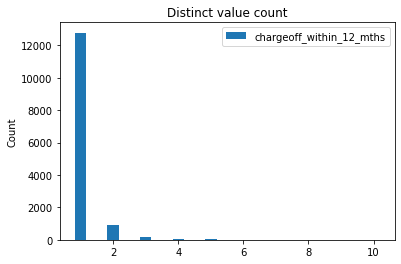

In [25]:
pd_chargeoff_within_12_mths = df_labelled.groupBy('chargeoff_within_12_mths').count().filter('chargeoff_within_12_mths > 0').toPandas()

draw_plot(pd_chargeoff_within_12_mths, 'chargeoff_within_12_mths')

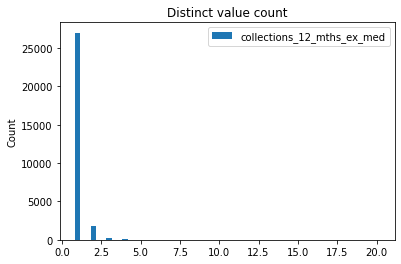

In [26]:
pd_collections_12_mths_ex_med = df_labelled.groupBy('collections_12_mths_ex_med').count().filter('collections_12_mths_ex_med > 0').toPandas()

draw_plot(pd_collections_12_mths_ex_med, 'collections_12_mths_ex_med')

In [27]:
df_labelled.groupBy('collections_12_mths_ex_med','is_default').count().orderBy('is_default','count').toPandas()

,collections_12_mths_ex_med,is_default,count
0,11,0,1
1,16,0,1
2,14,0,1
3,8,0,1
4,9,0,2
5,12,0,2
6,10,0,2
7,20,0,2
8,7,0,7
9,6,0,9


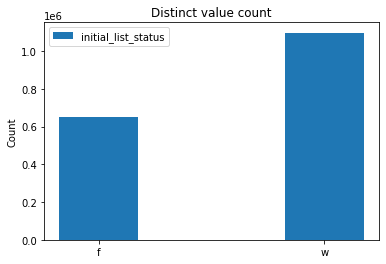

In [28]:
pd_initial_list_status = df_labelled.groupBy('initial_list_status').count().toPandas()

draw_plot(pd_initial_list_status, 'initial_list_status')

In [29]:
df_labelled.groupBy('initial_list_status','is_default').count().toPandas()

,initial_list_status,is_default,count
0,f,1,116951
1,w,0,915703
2,f,0,535312
3,w,1,182459


In [30]:
df_labelled.select('total_acc').distinct().count()

148

In [31]:
df_labelled.select('earliest_cr_line').distinct().show(5)

+----------------+
|earliest_cr_line|
+----------------+
|        Oct-1994|
|        Nov-2000|
|        Nov-1987|
|        Dec-1999|
|        Aug-2006|
+----------------+
only showing top 5 rows



In [32]:
df_labelled.select('earliest_cr_line').distinct().count()

738

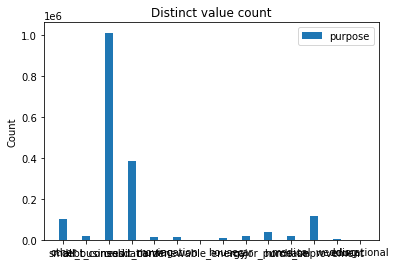

In [33]:
pd_purpose = df_labelled.groupBy('purpose').count().toPandas()

draw_plot(pd_purpose, 'purpose')

In [34]:
df_labelled.groupBy('purpose','is_default').count().orderBy('purpose','is_default').toPandas()

,purpose,is_default,count
0,car,0,16518
1,car,1,2349
2,credit_card,0,330308
3,credit_card,1,56419
4,debt_consolidation,0,825410
5,debt_consolidation,1,184453
6,educational,0,314
7,educational,1,50
8,home_improvement,0,99127
9,home_improvement,1,17411


In [35]:
df_labelled.groupBy('loan_status','is_default').count().orderBy('loan_status','is_default').toPandas()

,loan_status,is_default,count
0,Charged Off,1,299185
1,Current,0,166791
2,Default,1,225
3,Does not meet the credit policy. Status:Charge...,0,534
4,Does not meet the credit policy. Status:Fully ...,0,1526
5,Fully Paid,0,1276946
6,In Grace Period,0,1820
7,Late (16-30 days),0,517
8,Late (31-120 days),0,2881


## Select features for basic model
<a id='feature_selection'></a>

drop_cols = ['issue_mth','issue_year','issue_d','debt_settlement_flag','hardship_flag','tax_liens','pub_rec_bankruptcies','chargeoff_within_12_mths','policy_code',
             'last_fico_range_low','last_fico_range_high','last_credit_pull_d','last_pymnt_amnt','last_pymnt_d','collection_recovery_fee','recoveries','initial_list_status',
             'pub_rec','open_acc','inq_last_6mths','fico_range_high','fico_range_low','delinq_2yrs','earliest_cr_line','addr_state','zip_code','url','pymnt_plan','sub_grade',
             'installment','term','funded_amnt_inv','funded_amnt','id','_c0','out_prncp','out_prncp_inv','total_pymnt_inv']

In [86]:
#df_final = df_labelled.drop(*drop_cols)
df_final = df_labelled

In [87]:
df_final = df_final.withColumn("int_rate", F.expr("substring(int_rate, 1, length(int_rate)-1)").cast('double'))

In [88]:
df_final = df_final.withColumn("revol_util", F.expr("substring(revol_util, 1, length(revol_util)-1)").cast('double'))

In [89]:
df_final = df_final.withColumn("annual_inc", F.col('annual_inc').cast('double'))

In [90]:
df_final = df_final.withColumn("dti", F.col('dti').cast('double'))

In [91]:
df_final = df_final.withColumn("total_acc", F.col('total_acc').cast('int'))

In [92]:
df_final.printSchema()

root
 |-- loan_amnt: integer (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- dti: double (nullable = true)
 |-- revol_bal: integer (nullable = true)
 |-- revol_util: double (nullable = true)
 |-- total_acc: integer (nullable = true)
 |-- total_pymnt: double (nullable = true)
 |-- total_rec_prncp: double (nullable = true)
 |-- total_rec_int: double (nullable = true)
 |-- total_rec_late_fee: double (nullable = true)
 |-- collections_12_mths_ex_med: integer (nullable = true)
 |-- application_type: string (nullable = true)
 |-- acc_now_delinq: integer (nullable = true)
 |-- tot_coll_amt: integer (nullable = true)
 |-- tot_cur_bal: integer (nullable = true)
 |-- total_rev_hi_lim: integer (nullable = true)
 |-- acc_open_past_24mths: integer (nullable = true)
 |-- av

In [93]:
df_final.show(5)

+---------+--------+-----+--------------+----------+-------------------+------------------+-----+---------+----------+---------+----------------+---------------+-------------+------------------+--------------------------+----------------+--------------+------------+-----------+----------------+--------------------+-----------+-----------+----------+
|loan_amnt|int_rate|grade|home_ownership|annual_inc|verification_status|           purpose|  dti|revol_bal|revol_util|total_acc|     total_pymnt|total_rec_prncp|total_rec_int|total_rec_late_fee|collections_12_mths_ex_med|application_type|acc_now_delinq|tot_coll_amt|tot_cur_bal|total_rev_hi_lim|acc_open_past_24mths|avg_cur_bal|delinq_amnt|is_default|
+---------+--------+-----+--------------+----------+-------------------+------------------+-----+---------+----------+---------+----------------+---------------+-------------+------------------+--------------------------+----------------+--------------+------------+-----------+----------------+-

# Baseline Model

In [94]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import DenseVector
from pyspark.ml.classification import LinearSVC
from pyspark.ml.feature import OneHotEncoder, StringIndexer

In [95]:
def vectorize_cat_cols(df, cat_features):
    idx_cols = [column+"_index" for column in cat_features]
    enc_cols = [idx_column+"_vec" for idx_column in idx_cols]
    indexers = StringIndexer(inputCols=cat_features, outputCols=idx_cols)
    encoders = OneHotEncoder(inputCols=idx_cols, outputCols=enc_cols, dropLast=False)
    pipeline = Pipeline(stages=[indexers, encoders])
    df_r = pipeline.fit(df).transform(df)
    df_r = df_r.drop(*idx_cols)
    #df_r.select(*cat_features, *enc_cols).toPandas()
    return df_r
    

In [96]:
# Standard Scaler
def make_pipeline_numeric(spark_df):
    stages= []

    scale_cols = spark_df.columns
    scale_cols.remove('is_default')

    #Assembling mixed data type transformations:
    assembler = VectorAssembler(inputCols=scale_cols, outputCol="features")
    stages += [assembler]

    #Standard scaler
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=True)
    stages += [scaler]

    #Creating and running the pipeline:
    pipeline = Pipeline(stages=stages)
    pipelineModel = pipeline.fit(spark_df)
    out_df = pipelineModel.transform(spark_df)

    return out_df

In [97]:
cat_cols = [item[0] for item in df_final.dtypes if item[1].startswith('string')]
num_cols = [item[0] for item in df_final.dtypes if item[1].startswith('in') or item[1].startswith('dou')]
num_features, cat_features = num_cols, cat_cols

In [98]:
cat_cols

['grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'application_type']

In [99]:
num_cols

['loan_amnt',
 'int_rate',
 'annual_inc',
 'dti',
 'revol_bal',
 'revol_util',
 'total_acc',
 'total_pymnt',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'delinq_amnt',
 'is_default']

### Train test split

In [100]:
train = df_final.sampleBy("is_default", fractions={0: 0.6, 1: 0.6}, seed=10)

In [101]:
test = df_final.subtract(train)

### Feature Engineering

In [102]:
%time df_train_vec = vectorize_cat_cols(train, cat_features)

CPU times: user 25.3 ms, sys: 3.81 ms, total: 29.1 ms
Wall time: 7.19 s


In [103]:
df_train_vec = df_train_vec.drop(*cat_features)

In [104]:
df_train_vec.printSchema()

root
 |-- loan_amnt: integer (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- dti: double (nullable = true)
 |-- revol_bal: integer (nullable = true)
 |-- revol_util: double (nullable = true)
 |-- total_acc: integer (nullable = true)
 |-- total_pymnt: double (nullable = true)
 |-- total_rec_prncp: double (nullable = true)
 |-- total_rec_int: double (nullable = true)
 |-- total_rec_late_fee: double (nullable = true)
 |-- collections_12_mths_ex_med: integer (nullable = true)
 |-- acc_now_delinq: integer (nullable = true)
 |-- tot_coll_amt: integer (nullable = true)
 |-- tot_cur_bal: integer (nullable = true)
 |-- total_rev_hi_lim: integer (nullable = true)
 |-- acc_open_past_24mths: integer (nullable = true)
 |-- avg_cur_bal: integer (nullable = true)
 |-- delinq_amnt: integer (nullable = true)
 |-- is_default: integer (nullable = false)
 |-- grade_index_vec: vector (nullable = true)
 |-- home_ownership_index_vec: vector (nullable =

#### Moving label column to the end

In [105]:
cols = df_train_vec.columns

In [106]:
cols.remove('is_default')
print(cols)

['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_bal', 'revol_util', 'total_acc', 'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'delinq_amnt', 'grade_index_vec', 'home_ownership_index_vec', 'verification_status_index_vec', 'purpose_index_vec', 'application_type_index_vec']


In [107]:
df_train_vec = df_train_vec.select(*cols, 'is_default')

In [41]:
#df_train = make_pipeline_numeric(df_train_vec)

In [108]:
df_train_vec.printSchema()

root
 |-- loan_amnt: integer (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- dti: double (nullable = true)
 |-- revol_bal: integer (nullable = true)
 |-- revol_util: double (nullable = true)
 |-- total_acc: integer (nullable = true)
 |-- total_pymnt: double (nullable = true)
 |-- total_rec_prncp: double (nullable = true)
 |-- total_rec_int: double (nullable = true)
 |-- total_rec_late_fee: double (nullable = true)
 |-- collections_12_mths_ex_med: integer (nullable = true)
 |-- acc_now_delinq: integer (nullable = true)
 |-- tot_coll_amt: integer (nullable = true)
 |-- tot_cur_bal: integer (nullable = true)
 |-- total_rev_hi_lim: integer (nullable = true)
 |-- acc_open_past_24mths: integer (nullable = true)
 |-- avg_cur_bal: integer (nullable = true)
 |-- delinq_amnt: integer (nullable = true)
 |-- grade_index_vec: vector (nullable = true)
 |-- home_ownership_index_vec: vector (nullable = true)
 |-- verification_status_index_vec: v

In [110]:
df_train_vec.groupBy('is_default').count().show(10)

+----------+------+
|is_default| count|
+----------+------+
|         1|172501|
|         0|828205|
+----------+------+



## Model Training

In [111]:
from pyspark.ml.classification import RandomForestClassifier

def make_pipeline(spark_df, label_col):        
     
    #for c in spark_df.columns:
    #    spark_df = spark_df.withColumn(c, spark_df[c].cast("float"))
    
    stages= []

    #cols = ['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'funded_amnt']
    cols = spark_df.columns
    cols.remove(label_col)
    
    #spark_df = spark_df.withColumn('acc_now_delinq',F.abs(spark_df['acc_now_delinq']))
    #spark_df = spark_df.withColumn('acc_open_past_24mths',F.abs(spark_df['acc_open_past_24mths']))
    #spark_df = spark_df.withColumn('annual_inc',F.abs(spark_df['annual_inc']))
    #spark_df = spark_df.withColumn('avg_cur_bal',F.abs(spark_df['avg_cur_bal']))
    #spark_df = spark_df.withColumn('funded_amnt',F.abs(spark_df['funded_amnt']))
    
    #Assembling mixed data type transformations:
    assembler = VectorAssembler(inputCols=cols, outputCol="features")
    stages += [assembler]    
    
    #Scaling features
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
    stages += [scaler]
    
    
    #RF Classifier
    #rf = LinearSVC(featuresCol='features', labelCol='is_default')
    rf = RandomForestClassifier(labelCol=label_col, featuresCol='features', numTrees=10)
    stages += [rf]
    
    #Creating and running the pipeline:
    pipeline = Pipeline(stages=stages)
    pipelineModel = pipeline.fit(spark_df)

    return pipelineModel

In [112]:
pipelineModel = make_pipeline(df_train_vec, 'is_default')

## Model Evaluation

In [114]:
df_test_vec = vectorize_cat_cols(test, cat_features)

In [115]:
test_cols = df_test_vec.columns

In [116]:
test_cols.remove('is_default')

In [117]:
df_test_vec = df_test_vec.select(*test_cols, 'is_default')

In [118]:
df_model_pred = pipelineModel.transform(df_test_vec)

In [119]:
df_model_pred.orderBy('is_default','prediction').groupBy('is_default','prediction').count().show()

+----------+----------+------+
|is_default|prediction| count|
+----------+----------+------+
|         1|       0.0| 72544|
|         0|       0.0|548881|
|         1|       1.0| 42709|
|         0|       1.0|  2443|
+----------+----------+------+



In [120]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [121]:
evaluator = BinaryClassificationEvaluator(labelCol="is_default", rawPredictionCol="prediction")

In [122]:
auroc = evaluator.evaluate(df_model_pred, {evaluator.metricName: "areaUnderROC"})
auprc = evaluator.evaluate(df_model_pred, {evaluator.metricName: "areaUnderPR"})

print("Area under ROC Curve: {:.4f}".format(auroc))
print("Area under PR Curve: {:.4f}".format(auprc))

Area under ROC Curve: 0.6824
Area under PR Curve: 0.7026


In [123]:
y_true = df_model_pred.select(['is_default']).collect()
y_pred = df_model_pred.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88    553472
           1       0.17      0.07      0.10    115238

    accuracy                           0.78    668710
   macro avg       0.50      0.50      0.49    668710
weighted avg       0.71      0.78      0.74    668710



In [124]:
if auroc > 0.5:
    pipelineModel.write().overwrite().save(os.environ["STORAGE"]+"/svadivel/pipeline/baseline/")

In [125]:
spark.stop()